In [1]:
import autogen
import json
import os
import copy
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

# Load Data

In [2]:
# load the criteria
criteria_file_path = "output/final_filtered_criteria.json"
with open(criteria_file_path) as crit_file:
    criteria = json.load(crit_file)

criteria

{'efficiency': {'description': 'The conciseness of the solution and the use of the most efficient method to solve the problem.',
  'accepted_values': ['inefficient',
   'moderately_efficient',
   'highly_efficient']},
 'accuracy': {'description': 'The correctness of the solution provided for the math problem.',
  'accepted_values': ['0% - Completely incorrect',
   '25% - Partially correct',
   '50% - Mostly correct',
   '75% - Almost correct',
   '100% - Completely correct']},
 'completeness': {'description': 'The extent to which the solution covers all aspects of the problem.',
  'accepted_values': ['0% - Not complete',
   '25% - Partially complete',
   '50% - Mostly complete',
   '75% - Almost complete',
   '100% - Fully complete']},
 'clarity': {'description': 'The ease with which the solution can be understood by the target audience.',
  'accepted_values': ['0% - Not clear',
   '25% - Somewhat clear',
   '50% - Fairly clear',
   '75% - Mostly clear',
   '100% - Very clear']},
 'pre

In [3]:
# convert accepted value to score
level2score = defaultdict(lambda: defaultdict(int))
score2level = defaultdict(lambda: defaultdict(str))

for criterion in criteria:
     score = 0
     for v in criteria[criterion]["accepted_values"]:
        level2score[criterion][v] = score
        score2level[criterion][score] = v
        score += 1
print(level2score)

defaultdict(<function <lambda> at 0x15a6ec400>, {'efficiency': defaultdict(<class 'int'>, {'inefficient': 0, 'moderately_efficient': 1, 'highly_efficient': 2}), 'accuracy': defaultdict(<class 'int'>, {'0% - Completely incorrect': 0, '25% - Partially correct': 1, '50% - Mostly correct': 2, '75% - Almost correct': 3, '100% - Completely correct': 4}), 'completeness': defaultdict(<class 'int'>, {'0% - Not complete': 0, '25% - Partially complete': 1, '50% - Mostly complete': 2, '75% - Almost complete': 3, '100% - Fully complete': 4}), 'clarity': defaultdict(<class 'int'>, {'0% - Not clear': 0, '25% - Somewhat clear': 1, '50% - Fairly clear': 2, '75% - Mostly clear': 3, '100% - Very clear': 4}), 'presentation': defaultdict(<class 'int'>, {'poor': 0, 'fair': 1, 'excellent': 2}), 'steps delineation': defaultdict(<class 'int'>, {'0% - No steps delineated': 0, '25% - Few steps delineated': 1, '50% - Some steps delineated': 2, '75% - Most steps delineated': 3, '100% - All steps delineated': 4}), 

In [4]:
# load successful and failed sample
def read_without_groundtruth(file_name):
    """
    Read the mathproblem logs - bypassing any information about the ground truths.

    Args:
    - file_name (str): The single log file that wants to get evaluated.

    Returns:
    - str: The log file without any information about the ground truth answer of the problem.
    """
    f = open( file_name,"r").readlines()
    output_dictionary = ""
    for line in f:
        if "is_correct" not in line and "correct_ans" not in line and  "check_result"  not in line:
            output_dictionary += line
        elif "is_correct" in line:
            correctness = line.replace(",","").split(":")[-1].rstrip().strip()
    return [output_dictionary,correctness]

# Reading one successful and one failed example of the task
response_successful = read_without_groundtruth("../test/test_files/agenteval-in-out/samples/sample_math_response_successful.txt")[0]
response_failed = read_without_groundtruth("../test/test_files/agenteval-in-out/samples/sample_math_response_failed.txt")[0]

In [5]:
# Load the adversarial test cases
with open(f"output/adversarial_examples.json") as file:
    adversarial_test_cases = json.load(file)

In [6]:
# Load the original test cases
log_path = "../test/test_files/agenteval-in-out/agentchat_results"

original_test_cases = {}

for prefix in os.listdir(log_path):
    if prefix == '.DS_Store':
        continue
    for file_name in os.listdir(log_path+"/"+prefix):
        gameid = prefix+"_"+file_name
        
        if file_name.split('.')[-1]=='json':
            test_case , actual_label = read_without_groundtruth(log_path+"/"+prefix+'/'+file_name)
            original_test_cases[gameid] = test_case

# Load the new anchor examples

In [ ]:
NUM_SEEDS = 18

def get_no_stdevs_samples():
    results = defaultdict(list) # results[criterion] gives a list of [score, sys_msg_segment]
    evaluated_scores = defaultdict(lambda: defaultdict(list)) # evaluated_scores[criterion][game] gives a list of quantified results
    
    for seed in range(NUM_SEEDS):
        # Load outcome data for the current seed
        with open(f'output/evaluated_problems-{seed}.json', 'r') as file:
            outcome = json.load(file)
            
            for game in outcome:
                if game.split('.')[-1]=='json':
                    quantified_result = json.loads(outcome[game])['estimated_performance']

                    for criterion in quantified_result:
                        crit_key = quantified_result[criterion].strip("'").strip('"')
                        evaluated_scores[criterion][game].append(level2score[criterion][crit_key])
            
    for criterion in evaluated_scores:
        for game in evaluated_scores[criterion]: 
            stdev = statistics.stdev(evaluated_scores[criterion][game])
    
            if stdev <= 0:
                score = round(statistics.mean(evaluated_scores[criterion][game]))
                parts = game.split('_')
                prefix = '_'.join(parts[:-1])
                file_name = parts[-1]
                test_case , actual_label = read_without_groundtruth(log_path+"/"+prefix+'/'+file_name)
                results[criterion].append([score, f'Task evaluated as {score2level[criterion][score]} example: {test_case}\n'])

    results[criterion] = sorted(results[criterion], key=lambda x: x[0])
    
    sample_test_cases = defaultdict(list) #sample_test_cases[criterion] gives a list [long_sys_msg, short_sys_msg]

    for criterion in results:
        list_of_samples = []
        if len(results[criterion]) == 0:
            list_of_samples.append(f"Task successful example: {response_successful}\nTask failed example: {response_failed}\n")
            list_of_samples.append(f"Task successful example: {response_successful}\n")
        elif len(results[criterion]) == 1:
            list_of_samples.append(results[criterion][0][1])
            list_of_samples.append(results[criterion][0][1])
        else:
            samples = results[criterion]
            mid_index = (len(samples) // 2) - 1
            if mid_index + 1 < len(samples):
                list_of_samples.append(results[criterion][mid_index][1] + results[criterion][mid_index + 1][1])
            else:
                list_of_samples.append(results[criterion][mid_index - 1][1] + results[criterion][mid_index][1])
            list_of_samples.append(results[criterion][mid_index][1])
        sample_test_cases[criterion] = list_of_samples
    
    return sample_test_cases

In [ ]:
sample_test_cases = get_no_stdevs_samples() #sample_test_cases[criterion] gives a list [long_sys_msg, short_sys_msg]

with open(f"output/samples_for_improved_quantifier.json", "w") as file:
    json.dump(sample_test_cases,file,indent=2) 

In [9]:
with open(f"output/samples_for_improved_quantifier.json") as file:
    sample_test_cases = json.load(file) 
sample_test_cases

{'efficiency': ['Task evaluated as inefficient example: {\n  "problem": "Find the equation of the plane which bisects the angle between the planes $3x - 6y + 2z + 5 = 0$ and $4x - 12y + 3z - 3 = 0,$ and which contains the point $(-5,-1,-5).$  Enter your answer in the form\\n\\\\[Ax + By + Cz + D = 0,\\\\]where $A,$ $B,$ $C,$ $D$ are integers such that $A > 0$ and $\\\\gcd(|A|,|B|,|C|,|D|) = 1.$",\n  "level": "Level 5",\n  "type": "Precalculus",\n  "solution": "Suppose $P = (x,y,z)$ is a point that lies on a plane that bisects the angle between the planes $3x - 6y + 2z + 5 = 0$ and $4x - 12y + 3z - 3 = 0.$  (Note that there are two such bisecting planes.)  Then the distance from $P$ to both planes must be equal, so\\n\\\\[\\\\frac{|3x - 6y + 2z + 5|}{\\\\sqrt{3^2 + (-6)^2 + 2^2}} = \\\\frac{|4x - 12y + 3z - 3|}{\\\\sqrt{4^2 + (-12)^2 + 3^2}}.\\\\]Then\\n\\\\[\\\\frac{|3x - 6y + 2z + 5|}{7} = \\\\frac{|4x - 12y + 3z - 3|}{13}.\\\\]We want to remove the absolute value signs, in order to o

# Create Quantifier

In [10]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
)

%env AUTOGEN_USE_DOCKER=0

env: AUTOGEN_USE_DOCKER=0


In [11]:
quantifier_message_base = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
        You will be given a criterion a dictionary as follows {"description": criterion description , "accepted_values": possible accepted inputs for this key}.
        You are going to evaluate the test case against the given criterion for the given task.
        Return the assessed performance based on accepted values for each criteria, which must be one of the values provided in the accepted_values list.
        Return only the assessed performance and nothing else"""

In [12]:
quantifier_sys_msg = f"""Task: "Math problem solving".
Task description: "Given any question, the system needs to solve the problem as consisely and acccurately as possible"
"""

In [ ]:
outcome = {}

quantifier = autogen.AssistantAgent(
name = "quantifier",
llm_config = {"config_list": config_list},
system_message = quantifier_message_base)

for game in original_test_cases:
    if game in outcome:
        continue
    test_case = original_test_cases[game]
    adversarial_test_case = adversarial_test_cases[game]
    
    result = {"actual_success": actual_label, "estimated_performance": {}}

    for criterion in criteria:
        try:
            quantifier_user = autogen.UserProxyAgent(
                name = "quantifier_user",
                max_consecutive_auto_reply = 0,  # terminate without auto-reply
                human_input_mode = "NEVER",
            )
            cq_results = quantifier_user.initiate_chat(quantifier, message = quantifier_sys_msg + \
                                            "Evaluation criterion: " + criterion + "\n" + \
                                            "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                            sample_test_cases[criterion][0] + \
                                            "actual test case to evaluate: " + test_case)
            quantified_result = quantifier_user.last_message()["content"]
        except:
            try:
                quantifier_user = autogen.UserProxyAgent(
                    name = "quantifier_user",
                    max_consecutive_auto_reply = 0,  # terminate without auto-reply
                    human_input_mode = "NEVER",
                )
                cq_results = quantifier_user.initiate_chat(quantifier, message = quantifier_sys_msg + \
                                                "Evaluation criterion: " + criterion + "\n" + \
                                                "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                                sample_test_cases[criterion][1] + \
                                                "actual test case to evaluate: " + test_case)
                quantified_result = quantifier_user.last_message()["content"]
            except:
                continue
                    
        original_result = quantified_result

        try:
            quantifier_user_adv = autogen.UserProxyAgent(
                name = "quantifier_user_adv",
                max_consecutive_auto_reply = 0,  # terminate without auto-reply
                human_input_mode = "NEVER",
            )
            cq_results = quantifier_user_adv.initiate_chat(quantifier, message = quantifier_sys_msg + \
                                            "Evaluation criterion: " + criterion + "\n" + \
                                            "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                            sample_test_cases[criterion][0] + \
                                            "actual test case to evaluate: " + adversarial_test_case)
            quantified_result = quantifier_user_adv.last_message()["content"]
        except:
            try:
                quantifier_user_adv = autogen.UserProxyAgent(
                    name = "quantifier_user_adv",
                    max_consecutive_auto_reply = 0,  # terminate without auto-reply
                    human_input_mode = "NEVER",
                )
                cq_results = quantifier_user_adv.initiate_chat(quantifier, message = quantifier_sys_msg + \
                                                "Evaluation criterion: " + criterion + "\n" + \
                                                "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                                sample_test_cases[criterion][1] + \
                                                "actual test case to evaluate: " + adversarial_test_case)
                quantified_result = quantifier_user_adv.last_message()["content"]
            except:
                continue

        adversarial_result = quantified_result

        result['estimated_performance'][criterion] = [original_result, adversarial_result]        
        
    outcome[game] = json.dumps(result)
                        
# store the evaluated problems
with open(f"output/improved_quantifier_adversarial_evaluated_problems.json","w") as file:
    json.dump(outcome,file,indent=2)

In [18]:
with open(f"output/improved_quantifier_adversarial_evaluated_problems.json") as file:
    outcome = json.load(file)

# Plot

In [19]:
adversarial_performance = defaultdict(lambda: defaultdict(int))# adversarial_performance[criterion] = {"better": cnt, "same": cnt, "worse": cnt}
key_errors = defaultdict(int)

for game in outcome:
    evaluated_results = json.loads(outcome[game])['estimated_performance']
    for criterion in evaluated_results:
        original_level, adversarial_level = evaluated_results[criterion]
        
        try: 
            original_score = level2score[criterion][original_level.strip('"').strip("'")]
            adversarial_score = level2score[criterion][adversarial_level.strip('"').strip("'")]
        except:
            if not original_level.strip('"').strip("'") in level2score[criterion].keys():
                key_errors[original_level.strip('"').strip("'")] += 1
            if not adversarial_level.strip('"').strip("'") in level2score[criterion].keys():
                key_errors[adversarial_level.strip('"').strip("'")] += 1
            continue
                
        comparison = 'better'
        if adversarial_score == original_score:
            comparison = 'same'
            if adversarial_score == 0:
                comparison = 'lowest'
            elif adversarial_score == len(criteria[criterion]['accepted_values']) - 1:
                comparison = 'highest'
        elif adversarial_score < original_score:
            comparison = 'worse'
        adversarial_performance[criterion][comparison] += 1

print(key_errors)

defaultdict(<class 'int'>, {})


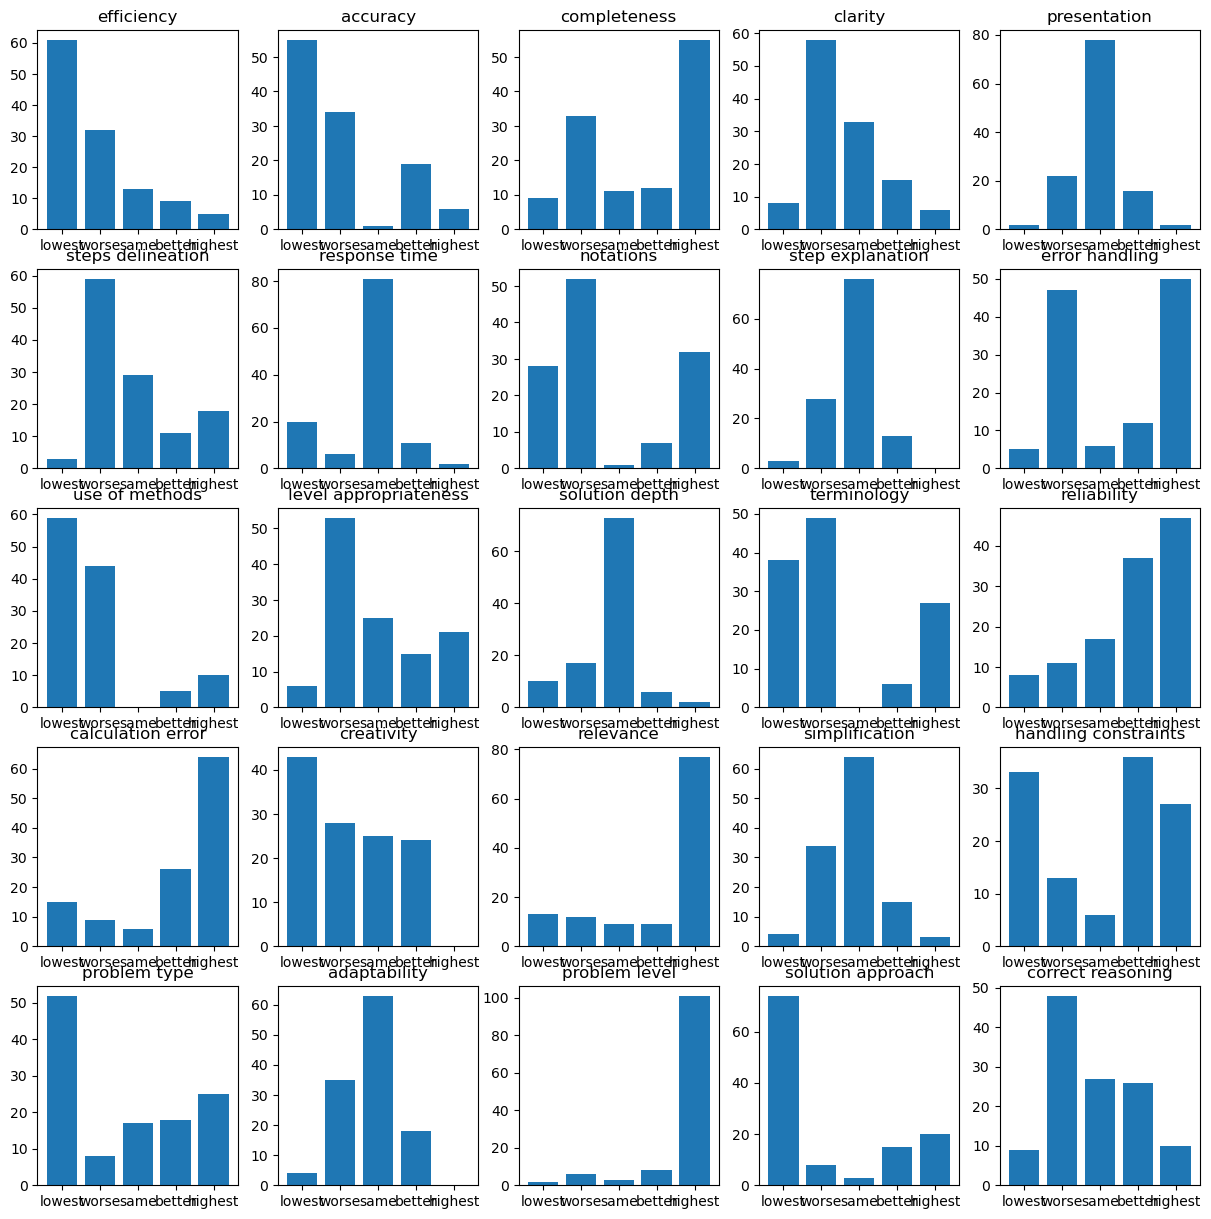

In [20]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

comparisons = ["lowest", "worse", "same", "better", "highest"]

for index, criterion in enumerate(adversarial_performance):
    counts = [adversarial_performance[criterion]['lowest'], adversarial_performance[criterion]['worse'], adversarial_performance[criterion]['same'], adversarial_performance[criterion]['better'], adversarial_performance[criterion]['highest']]
    axs[index//5, index%5].bar(comparisons, counts)
    axs[index//5, index%5].title.set_text(criterion)

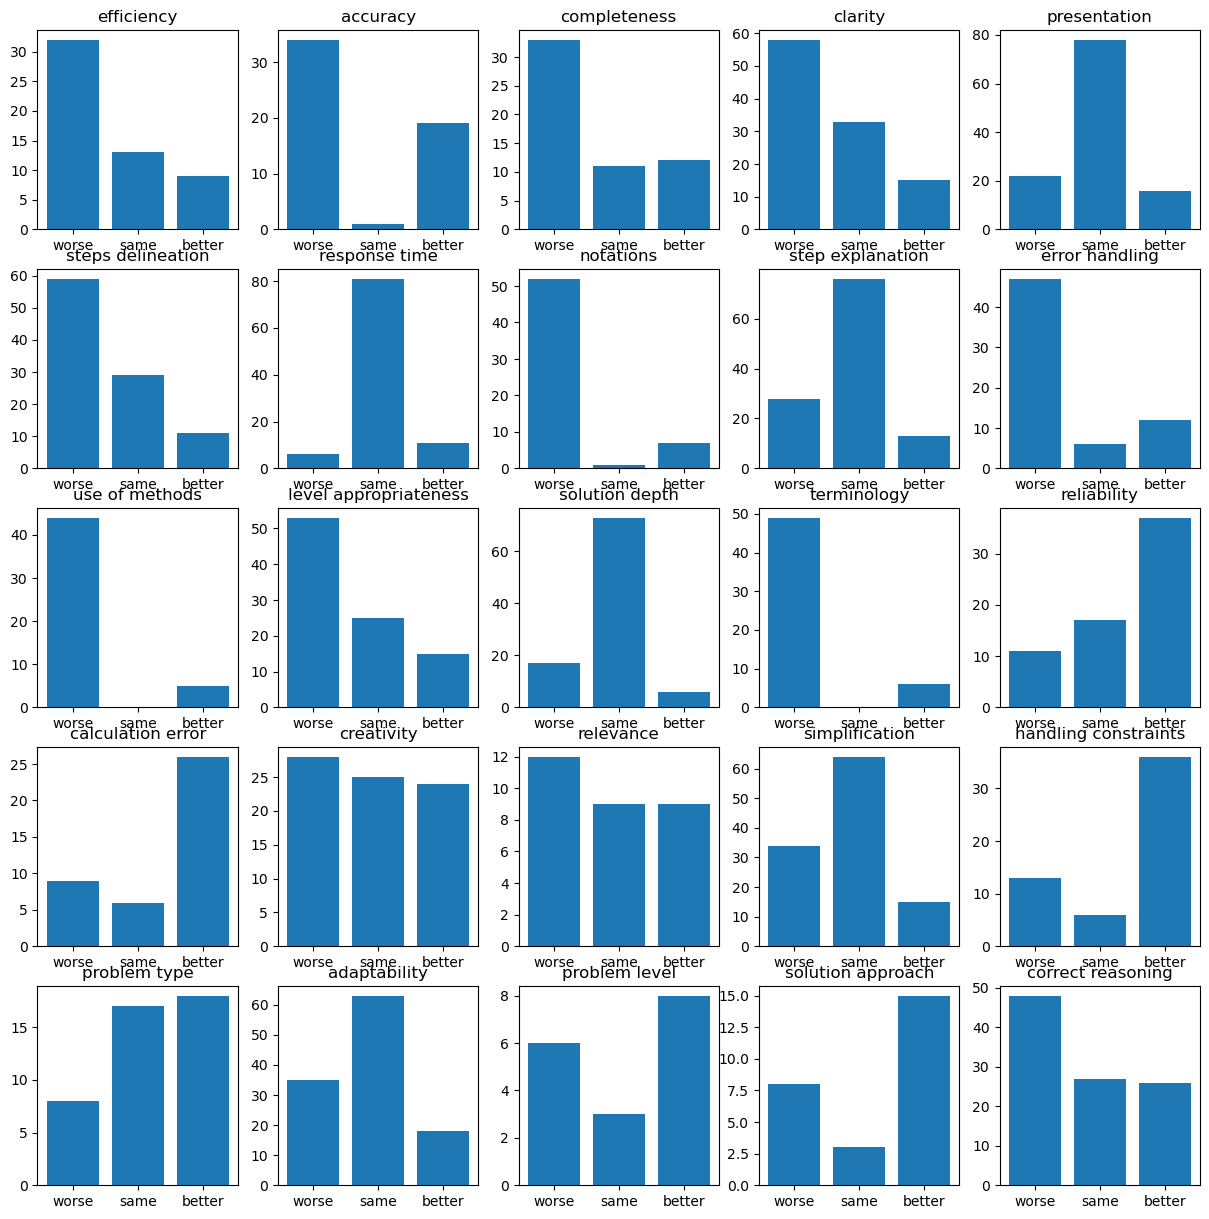

In [21]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

comparisons = ["worse", "same", "better"]

for index, criterion in enumerate(adversarial_performance):
    counts = [adversarial_performance[criterion]['worse'], adversarial_performance[criterion]['same'], adversarial_performance[criterion]['better']]
    axs[index//5, index%5].bar(comparisons, counts)
    axs[index//5, index%5].title.set_text(criterion)

In [22]:
fig.savefig('improved_quantifier_adversarial_performance.png')